In [1]:
# Import all necessary libraries
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Função mágica do Jupyter que habilita figuras interativas.
%matplotlib notebook

In [2]:
# Always reset the pseudo-random numbers generator to a known value so that your results are always the same.
np.random.seed(1234)

### Informações do exemplo

A **função objetivo** do exemplo é dada por

$$y = a_1 x_1 + a_2 x_2, \text{(equação de um plano)}$$

onde $a_1=1$ e $a_2=1$.

A **função hipótese** que iremos usar tem o seguinte formato

$$h(x) = \hat{a}_1 x_1 + \hat{a}_2 x_2, \text{(equação de um plano)}$$

onde $\hat{a}_1$ e $\hat{a}_2$ são os parâmetros (ou seja, os pesos) que queremos encontrar.

A função do **erro quadrático médio** para essa **função hipótese** é dada por

$$J_{e}(\hat{\textbf{a}})= \frac{1}{N}\sum_{n=0}^{N-1}{[ y(n) - (\hat{a}_1 x_1(n) + \hat{a}_2 x_2(n) )]^2}.$$

Cada **elemento** do **vetor gradiente** é dado por

$$\frac{\partial J_{e}(\hat{\textbf{a}})}{\partial \hat{a}_k} = -\frac{2}{N}\sum_{n=0}^{N-1}{[ y(n) - (\hat{a}_1 x_1(n) + \hat{a}_2 x_2(n) )]x_k(n)}, k = 1, 2.$$

O **vetor gradiente** em forma matricial é dado por

$$\frac{\partial J_{e}(\hat{\textbf{a}})}{\partial \hat{\textbf{a}}}= -\frac{2}{N}\textbf{X}^{T} (\textbf{y} - \hat{\textbf{y}} ), $$

onde $\textbf{X}$ é a matriz de atributos, com dimensão $N \times K$, $\textbf{y}$ é um vetor coluna com dimensão $N \times 1$ contendo todos os valores esperados e $\hat{\textbf{y}}$ é outro vetor coluna com dimensão $N \times 1$ contendo todas as saídas da função hipótese.

A **equação de atualização dos pesos** pode ser escrita em formato matricial como

$$\hat{\textbf{a}} = \hat{\textbf{a}} - \frac{\partial J_{e}(\hat{\textbf{a}})}{\partial \hat{\textbf{a}}} \\ \;\;\;\;\;\;\;\;\;= \hat{\textbf{a}} + \alpha \textbf{X}^{T} (\textbf{y} - \hat{\textbf{y}} ).$$

**OBS. 1**: Por ser constante, o termo $2∕N$ foi absorvido pelo passo de aprendizagem, $\alpha$.

**OBS. 2**: Percebam que não temos peso de bias (ou intercept), $a_0$, e, portanto, não precisamos do atributo de bias, $x_0$, (valor sempre igual a 1).

### Definição de funções úteis

In [3]:
def calculateErrorSurface(X, y):
    """Generate data points for plotting the error surface."""
    # Get the number of examples.
    N = len(y)

    # Generate values for parameters.
    M = 200
    a1 = np.linspace(-12.0, 14.0, M)
    a2 = np.linspace(-12.0, 14.0, M)
    # Generate the mesh grid.
    A1, A2 = np.meshgrid(a1, a2)

    # Get the attributes
    x1 = X[:,0].reshape(N, 1)
    x2 = X[:,1].reshape(N, 1)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            # Hypothesis function.
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            # Calculate the MSE.
            J[iter1, iter2] = (1.0/N)*np.sum(np.square(y - yhat))

    return J, A1, A2

def calculateClosedFormSolution(X, y):
    """Calculate closed-form solution using the normal equation."""
    # Get the number of examples.
    N = len(y)
    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y))
    yhat = X.dot(a_opt)
    Joptimum = (1.0/N)*np.sum(np.power((y - yhat), 2))

    return Joptimum, a_opt

def batchGradientDescent(X, y, alpha, maxNumEpoch):
    """Batch gradient descent solution."""
    # Get the number of training examples.
    N = len(y)

    # Initialize error history with zeros.
    Jgd = np.zeros(maxNumEpoch+1)

    # Initialization of parameters (weights are generally random initialized).
    a = np.array([-10.0, -10.0]).reshape(2, 1)

    # Create matrix for parameter history.
    a_hist = np.zeros((2, maxNumEpoch+1))
    # Initialize history matrix.
    a_hist[:, 0] = a.reshape(2,)

    # Hypothesis function.
    yhat = X.dot(a)
    # Initial MSE.
    Jgd[0] = (1.0/N)*np.sum(np.power(y - yhat, 2))

    # Initialize gradient history matrix with zeros.
    grad_hist = np.zeros((2, maxNumEpoch))

    # Batch gradient-descent loop.
    error = 1 # Error between consecutive epochs.
    epoch = 0 # Epoch counter.
    while(error > 1e-5 and epoch < maxNumEpoch-1):

        # Calculate the gradient vector.
        yhat = X.dot(a)
        gradients = -X.T.dot(y - yhat)

        # Update the weights.
        a = a - alpha * gradients

        # Store new weights into the matrix.
        a_hist[:, epoch+1] = a.reshape(2,)

        # Calculate and store the MSE for the new weights.
        yhat = X.dot(a)
        Jgd[epoch+1] = (1.0/N)*sum(np.power((y - yhat), 2))

        # Calculate the error between consecutive epochs.
        error = np.abs(Jgd[epoch]-Jgd[epoch+1])

        # Update the gradient history.
        grad_hist[:, epoch] = gradients.reshape(2,)

        # Increment the epoch.
        epoch += 1

    return a, a_hist, Jgd, grad_hist, epoch

### Geração do conjunto de dados.

**OBS**.: Os atributos não precisam ser valores aleatórios como nesse exemplo, eles poderiam ser, por exemplo, valores determinísticos em um intervalo qualquer.

In [4]:
# Number of pairs features/label.
N = 10000

# Attributes (vetores coluna).
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# True function.
y = x1 + x2

# Noise (vetor coluna).
w = np.random.randn(N, 1)

# Labels (rótulos).
y_noisy = y + w

### Visualizando o conjunto de dados original e ruidoso

<IPython.core.display.Javascript object>


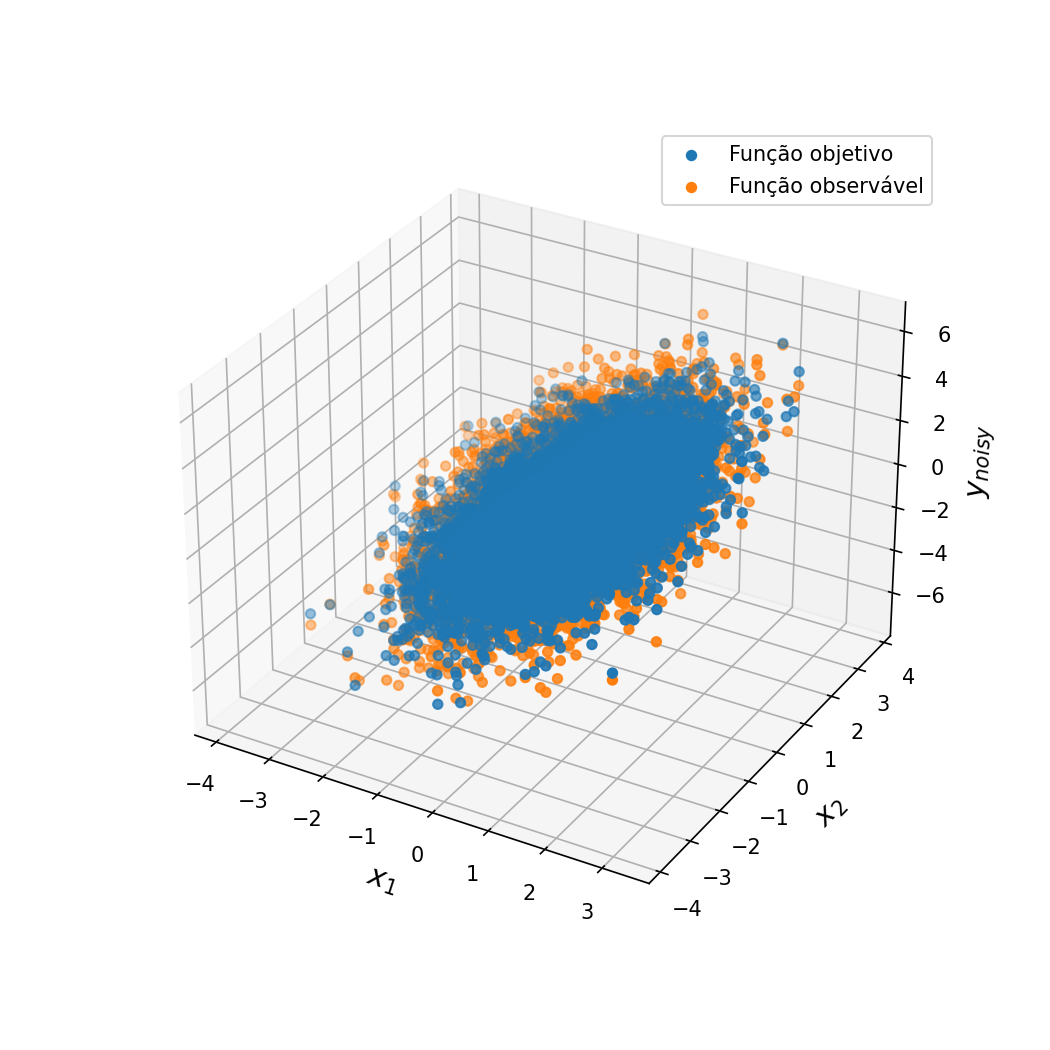

In [5]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()

ax.scatter(x1, x2, y, label='Função objetivo')
ax.scatter(x1, x2, y_noisy, label='Função observável')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$y_{noisy}$', fontsize=14)
ax.legend()
plt.show()

### Plotando os histogramas normalizados de $x_1$ e $x_2$.

Percebam que os **dois atributos têm intervalos de variação bastante similares**, consequentemente, a superfíce de erro terá **formato de tigela** e a superfície de contorno será **circular**.

**OBS**.: Os histogramas abaixo estão normalizados, o que significa que são aproximações das FDPs de $x_1$ e $x_2$, as quais sabemos, seguem a distribuição Gaussiana.

<IPython.core.display.Javascript object>


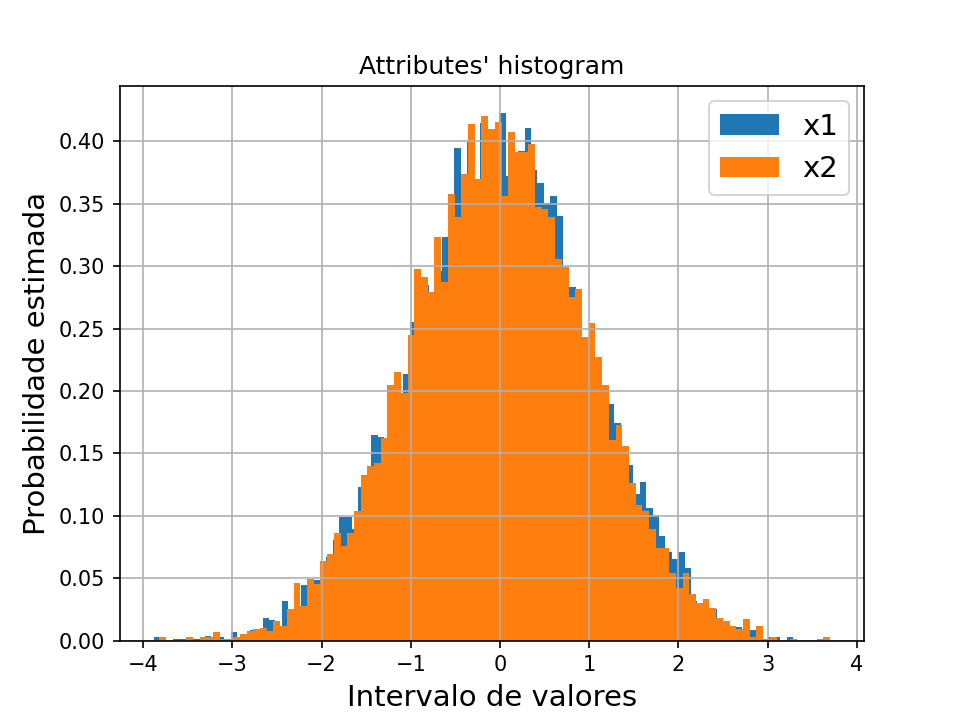

In [6]:
plt.figure()
plt.hist(x1, bins=100, density=True, label='x1')
plt.hist(x2, bins=100, density=True, label='x2')
plt.legend(fontsize=14)
plt.grid()
plt.title('Attributes\' histogram')
plt.xlabel('Intervalo de valores', fontsize=14)
plt.ylabel('Probabilidade estimada', fontsize=14)
plt.show()

### Criando a matriz de atributos

Para que possamos representar a **função hipótese em formato matricial** e, consequentemente, termos o **vetor gradiente também em formato matricial**, precisamos criar uma matriz de atributos que seja o resultado da concatenação dos dois vetores coluna, $x_1$ e $x_2$.

In [7]:
# Concatena os vetores coluna x1 e x2, formando, assim, uma matriz de atributos com dimensões NxK.
X = np.c_[x1, x2]

### Plotando a superfície de erro

<IPython.core.display.Javascript object>


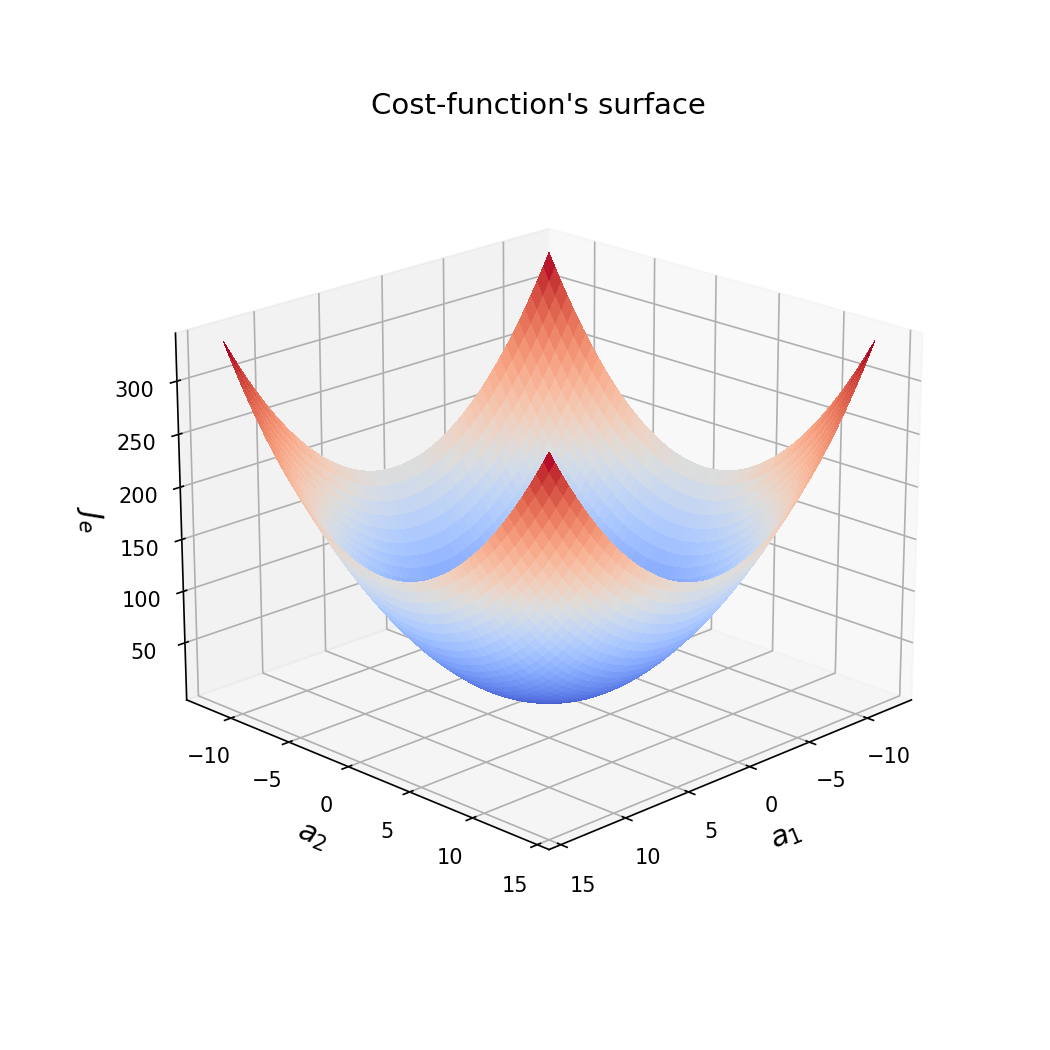

In [8]:
# Calculate data point for plotting error surface.
J, A1, A2 = calculateErrorSurface(X, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14);
plt.title('Cost-function\'s surface', fontsize=14)
ax.view_init(20, 45)
#Show the plot.
plt.show()

### Encontrando o ponto de mínimo com a equação normal

**OBS**.: Observem que o valor do **MSE é próximo da variância do ruído** adicionado às amostras da função objetivo. Portanto, conforme nós discutimos anteriormente, o **menor valor possível** para o MSE será **limitado pelo ruído** presente nas amostras.

In [9]:
Joptimum, a_opt = calculateClosedFormSolution(X, y_noisy)

print('a1_opt:', a_opt[0, 0])
print('a2_opt:', a_opt[1, 0])
print('Joptimum:', Joptimum)

a1_opt: 1.0032994113858922
a2_opt: 0.9999704951023062
Joptimum: 0.995225680139118


### Encontrando o ponto de mínimo com o gradiente descendente

In [10]:
# Gradient-descent solution.
maxNumEpoch = 10000

# learning step.
alpha = 0.0001 # Valor empírico "ideal": convergência rápida.

# Run batch gradient-descent algorithm.
a, a_hist, Jgd, grad_hist, epoch = batchGradientDescent(X, y_noisy, alpha, maxNumEpoch)

# Print weights and MSE.
print('a1_gd:', a[0, 0])
print('a2_gd:', a[1, 0])
print('Jgd:', Jgd[epoch])

a1_gd: 1.0032985803955174
a2_gd: 0.9999694920190179
Jgd: 0.9952256801407825


### Plotando a superfície de contorno com o histórico de atualizações dos pesos

A figura mostra as atualizaçoes feitas pelo algoritmo até a convergência, ou seja, até atingir o ponto de mínimo.

<IPython.core.display.Javascript object>


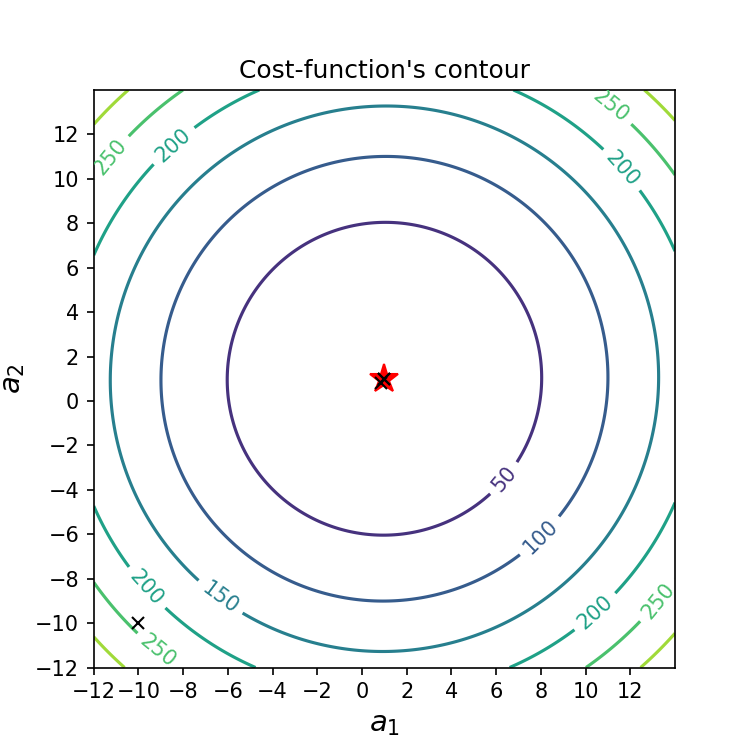

In [11]:
fig = plt.figure(figsize=(5,5))

cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s contour')

plt.plot(a_opt[0], a_opt[1], c='r', marker='*', markersize=14)
plt.plot(a_hist[0, 0:epoch], a_hist[1, 0:epoch], 'kx')

plt.xticks(np.arange(-12, 14, step=2.0))
plt.yticks(np.arange(-12, 14, step=2.0))

plt.show()

**Observações**

+ O algoritmo segue **diretamente na direção de máximo decrescimento** da superfície de erro, ou seja, como o erro varia de forma similar em ambas as direções, a atualização dos pesos segue um caminho reto entre $a_1$ e $a_2$ (formando $\approx 45^{\circ}$ entre os eixos dos pesos).
<br/><br/>

+ Vejam que com o passo de aprendizagem ideal, o algoritmo se aproxima do ponto de mínimo em poucos passos (i.e., rapidamente).

### Gráfico com número de épocas de treinamento versus o erro

**Observação**

+ **Época**: é uma passagem completa por todos os exemplos do conjunto de treinamento.
+ **Iteração**: é uma única atualização dos pesos do modelo, geralmente realizada com um subconjunto de exemplos do conjunto de treinamento.

Por exemplo, com o gradiente descendente em batelada, uma iteração é igual a uma época, pois usa-se todos os exemplos do conjunto de treinamento para atualizar os pesos. Porém, com o GDE, uma época é igual a $N$ iterações, pois a cada iteração de atualização dos pesos, usa-se apenas uma amostra para estimar o vetor gradiente.

<IPython.core.display.Javascript object>


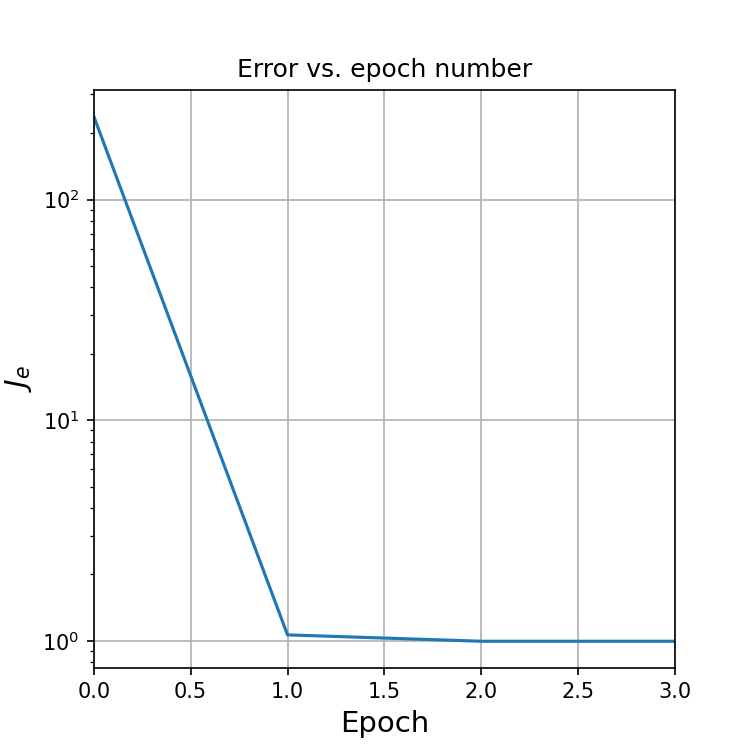

In [12]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, epoch), Jgd[0:epoch])
plt.xlim((0, epoch-1))
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. epoch number')
plt.grid()
plt.show()

### Plotando as funções objetivo e observável juntamente com o plano (i.e., a função hipótese) encontrado com o gradiente descendente em batelada.

<IPython.core.display.Javascript object>


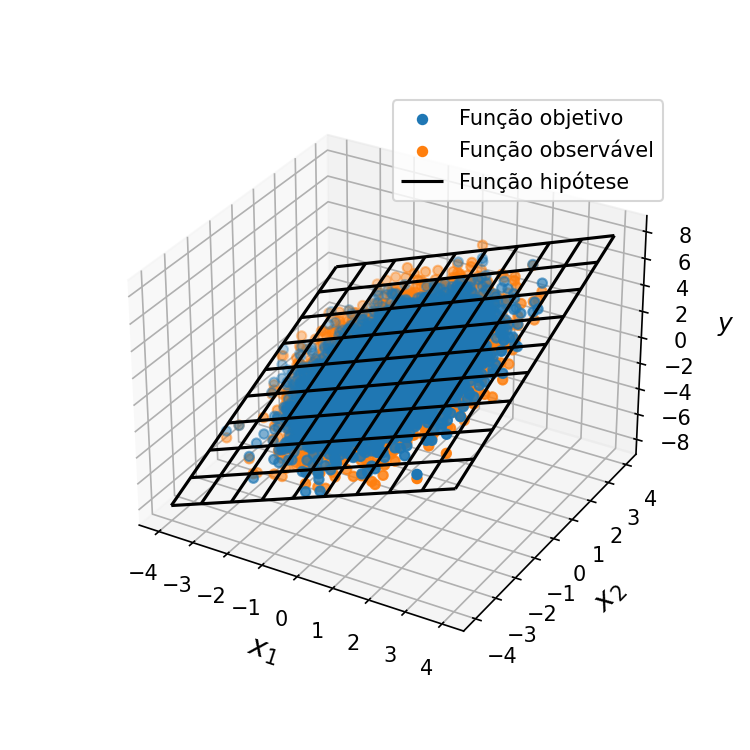

In [13]:
# Plot cost-function surface.
fig = plt.figure(figsize=(5,5))
plt.subplot(projection='3d')
ax = fig.gca()

M = 10
x1_ = np.linspace(-4.0, 4.0, M)
x2_ = np.linspace(-4.0, 4.0, M)
X1, X2 = np.meshgrid(x1_, x2_)
Y = a[0, 0]*X1 + a[1, 0]*X2

ax.scatter(x1, x2, y, label='Função objetivo')
ax.scatter(x1, x2, y_noisy, label='Função observável')
ax.plot_wireframe(X1, X2, Y, color="black", label='Função hipótese')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$y$', fontsize=12)
plt.legend()
plt.show()

### Plotando a variação do gradiente ao longo do treinamento

Lembrem-se que os pesos $\hat{a}_1$ e $\hat{a}_2$ foram inicializados em -10 e -10, respectivamente.

Portanto, eles estão à **esquerda do valor ótimo** ($a_1 = a_2 = 1$), o que vai resultar em **derivadas parciais negativas**.

Assim, o **termo de atualização será positivo** e fará com que o valor dos pesos se torne positivo, tendendo ao valor 1 (i.e., o valor original dos pesos da função objetivo), ao longo das épocas de treinamento.

$$\hat{\textbf{a}} = \hat{\textbf{a}} - \frac{\partial J_{e}(\hat{\textbf{a}})}{\partial \hat{\textbf{a}}}$$

<IPython.core.display.Javascript object>


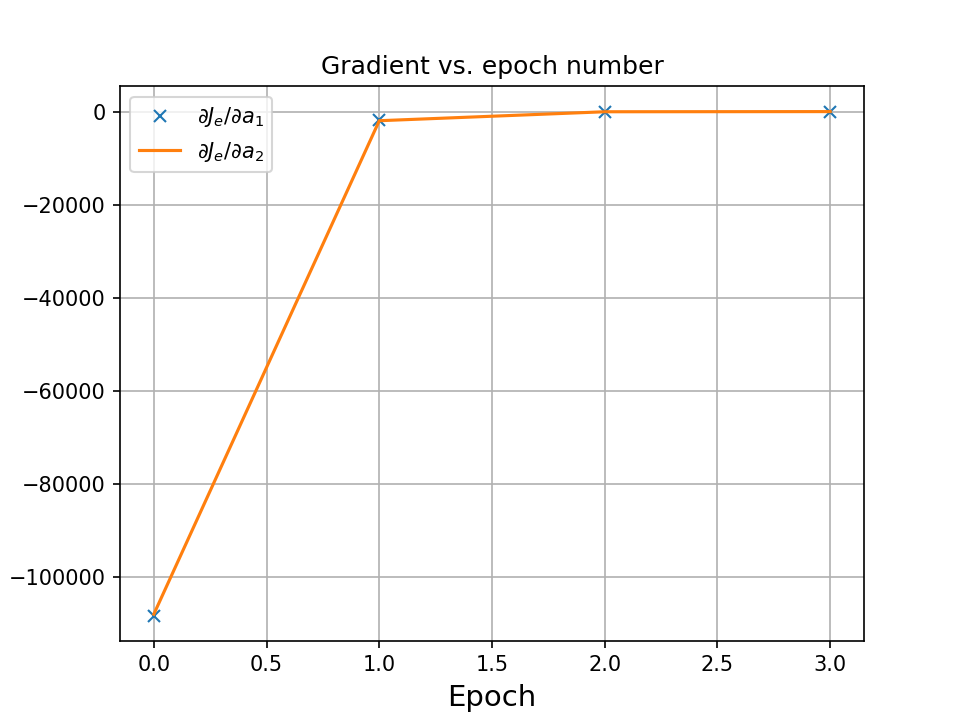

In [14]:
fig = plt.figure()

plt.plot(np.arange(0, epoch), grad_hist[0, 0:epoch], 'x', label='$ \partial J_{e} / \partial a_1$')
plt.plot(np.arange(0, epoch), grad_hist[1, 0:epoch], label='$ \partial J_{e} / \partial a_2$')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('$\\nabla_e$', fontsize=14)
plt.title('Gradient vs. epoch number')
plt.legend()
plt.grid()

plt.show()

### Conclusões

+ Os elementos do vetor gradiente **convergem rapidamente para o valor zero**, ou seja, o ponto da superfície com inclinação igual a 0 (i.e., o ponto de mínimo da superfície convexa).
<br/><br/>

+ Após três épocas, as **atualizações** aplicadas aos pesos são **muito pequenas** e, portanto, podemos **declarar o término do treinamento**, i.e., a **convergência**.
<br/><br/>

+ Percebam que as **magnitudes dos elementos do vetor gradiente são muito grandes** e é por isso que usamos um passo de aprendizagem, para usar apenas **uma porcentagem dessa informação e não ultrapassar o ponto de mínimo**.